# SBERT Multilingual Experiments

# Things You Don't Need to Run

## List of Things to Install

In [ ]:
!pip install pandas
!pip install -U sentence-transformers
!pip install --upgrade ipywidgets
!pip install numpy==1.24.2
!pip install mecab-python3
!pip install unidic-lite
!pip install tensorflow
!pip install tensorflow-datasets

# Things You Need to Run

## List of Things to Import 

In [1]:
import pandas as pd
from tqdm import tqdm as tqdm
from sentence_transformers import SentenceTransformer, models, SentencesDataset, InputExample, losses, evaluation, readers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.datasets import ParallelSentencesDataset
import datetime
from torch.utils.data import DataLoader
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import numpy as np

## Create Models
### References
+ Code: https://gist.github.com/vumichien/c920398b9739e14ecd0e4ca6a6a02d9d
+ Teacher Model (all-mpnet-base-v2):
  + https://www.sbert.net/docs/pretrained_models.html
  + https://huggingface.co/sentence-transformers/all-mpnet-base-v2
+ Student Model (bert-base-multilingual-cased): https://huggingface.co/bert-base-multilingual-cased

### Parameters
+ max_seq_length = 128: the maximum number of tokens of the input
+ train_batch_size = 16: the number of samples that leads to one step of model update

In [2]:
max_seq_length = 128
train_batch_size = 16

### Teacher Model: all-mpnet-base-v2
+ An all-round sentence-transformers model tuned for many use-cases
+ Trained on a large and diverse dataset comprising over 1 billion training pairs
+ Maps sentences and paragraphs to a 768 dimensional dense vector space

In [3]:
teacher_model = SentenceTransformer('all-mpnet-base-v2')

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


### Student Model: bert-base-multilingual-cased
+ Trained on the top 104 languages with the largest Wikipedia data
+ Uses two objectives: MLM and NSP
+ Masked language modeling (MLM): 
    + randomly masks 15% of words in an input sentence
    + predicts the masked words
    + enables the model to learn a bidirectional representation of the sentence
+ Next sentence prediction (NSP): 
    + concatenates two masked sentences as inputs during pretraining
    + predicts whether the sentences follow each other


In [4]:
student_model = models.Transformer("bert-base-multilingual-cased")

### Pooling Model
+ word_embedding_dimension: dimensions for the word embedding
+ pooling_mode_mean_tokens: perform mean pooling: average all of the contextualized word embeddings produced by BERT
+ pooling_mode_cls_token: use the first token (CLS token) as text representation
+ pooling_mode_max_tokens: use max in each dimension over all tokens
  + e.g. Token 1: [2, 5], Token 2: [3, 6], Token 3: [1, 8] -> [3, 8]

In [5]:
pooling_model = models.Pooling(student_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

### Custom Sentence Transformer Model: Student Model + Pooling Model
+ 'modules' parameter is used to create custom SentenceTransformer models

In [6]:
model = SentenceTransformer(modules=[student_model, pooling_model])

## Load Dataset
### References
+ Dataset: https://jipsti.jst.go.jp/aspec/
    + Abstracts of scientific research papers
    + 3.0M sentences

### Data Cleaning Process
+ Train the bert-base-multilingual-cased model on a corpus consisting of 130,000 sentence pairs
+ Generate sentence embeddings for both English and Japanese sentences using the trained model
+ Compute similarity scores for all sentence pairs, with values ranging from 0.0 to 1.0
+ Manually check pairs with a similarity score below 0.6 and remove misaligned sentence pairs from the dataset
+ Replace full-width characters with half-width characters to ensure uniformity


### MeCab
+ MeCab is an open-source text segmentation library for use with text written in the Japanese language

### Train Set
+ ParallelSentenceDataset is a dataset reader that is used to read parallel sentences
+ Load the training dataset
+ Create a data loader for the training dataset
  + 'train_reader' dataset is passed to the data loader
  + shuffle is set to True to have the data reshuffled at every epoch
  + batch_size (int, optional) is the number of samples per batch to load
+ Set up the MSE loss function for training the student model

In [7]:
train_reader = ParallelSentencesDataset(student_model=model, teacher_model=teacher_model)
train_reader.load_data('train_1M_updated.tsv')
train_dataloader = DataLoader(train_reader, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MSELoss(model=model)

### Dev Set
+ The code for the evaluators has changed across versions, and now, when using EmbeddingSimilarityEvaluator, you no longer pass a data loader: https://github.com/UKPLab/sentence-transformers/blob/master/examples/evaluation/evaluation_stsbenchmark_sbert-wk.py

In [8]:
evaluators = []
sts_reader = readers.STSDataReader('', s1_col_idx=0, s2_col_idx=1, score_col_idx=2)
evaluator_sts = EmbeddingSimilarityEvaluator.from_input_examples(sts_reader.get_examples('dev_large_updated.tsv'))
evaluators.append(evaluator_sts)

### Test Set
+ Load the test dataset
+ The source sentences and target sentences are extracted and converted to lists.
+ Evaluate the Mean Squared Error (MSE) between the source sentences and target sentences 

In [9]:
test_reader = ParallelSentencesDataset(student_model=model, teacher_model=teacher_model)
test_reader.load_data('test_large_updated.tsv')
df = pd.read_csv("test_large_updated.tsv", sep='\t', header=None)
source_sentences = df.iloc[:, 0].tolist()
target_sentences = df.iloc[:, 1].tolist()
test_mse = evaluation.MSEEvaluator(source_sentences, target_sentences, teacher_model=teacher_model, show_progress_bar = False, batch_size = train_batch_size, name = 'test', write_csv = True)
evaluators.append(test_mse)

## Calculate Cosine Similarity Before Training
+ Read the training dataset into a Pandas DataFrame
+ Extract Japanese and English sentences from the DataFrame and convert them into lists
+ Create lists to store embeddings for English and Japanese sentences, respectively
+ Iterate over pairs of English and Japanese sentences from the test dataset to calculate embeddings and store them in the lists
+ Convert the lists of embeddings into NumPy arrays
+ Calculate the cosine similarity for all pairs of embeddings
+ Calculate the mean cosine similarity

In [ ]:
from scipy import spatial

df_test_updated = pd.read_csv('test_large_updated.tsv', sep='\t', header=None, names=['English sentence', 'Japanese sentence', 'scores'])
sentences_en_test = df_test_updated['English sentence'].tolist()
sentences_ja_test = df_test_updated['Japanese sentence'].tolist()

embeddings_en_test_untrained = []
embeddings_ja_test_untrained = []
for s1, s2 in zip(sentences_en_test, sentences_ja_test):
    embeddings_en = model.encode(s1, convert_to_tensor=True)
    embeddings_ja = model.encode(s2, convert_to_tensor=True)
    embeddings_en_test_untrained.append(embeddings_en)
    embeddings_ja_test_untrained.append(embeddings_ja)

embeddings_en_test_untrained = np.array([emb.cpu().numpy() for emb in embeddings_en_test_untrained])
embeddings_ja_test_untrained = np.array([emb.cpu().numpy() for emb in embeddings_ja_test_untrained])

cos_similarities_untrained = []

for emb_en_untrained, emb_ja_untrained in zip(embeddings_en_test_untrained, embeddings_ja_test_untrained):
    cos_sim_untrained = 1 - spatial.distance.cosine([emb_en_untrained], [emb_ja_untrained])
    cos_similarities_untrained.append(cos_sim_untrained)

cos_similarities_untrained

mean_cos_similarity_untrained = np.mean(cos_similarities_untrained)
print("Mean Cosine Similarity Score Before Training:", mean_cos_similarity_untrained)

In [ ]:
cos_similarities_untrained

In [ ]:
output_path = "output/model-" + datetime.datetime.now().strftime("%Y-%m-%d")
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1]),
          epochs=20,
          evaluation_steps=1000,
          warmup_steps=10000,
          scheduler='warmupconstant',
          output_path=output_path,
          save_best_model=True,
          optimizer_params= {'lr': 2e-5, 'eps': 1e-6}
          )

## Calculate Cosine Similarity After Training

In [13]:
embeddings_en_test_trained = []
embeddings_ja_test_trained = []

for s1, s2 in zip(sentences_en_test, sentences_ja_test):
    embeddings_en_trained = model.encode(s1, convert_to_tensor=True)
    embeddings_ja_trained = model.encode(s2, convert_to_tensor=True)
    embeddings_en_test_trained.append(embeddings_en_trained)
    embeddings_ja_test_trained.append(embeddings_ja_trained)

embeddings_en_test_trained = np.array([emb.cpu().numpy() for emb in embeddings_en_test_trained])
embeddings_ja_test_trained = np.array([emb.cpu().numpy() for emb in embeddings_ja_test_trained])

cos_similarities_trained = []

for emb_en_trained, emb_ja_trained in zip(embeddings_en_test_trained, embeddings_ja_test_trained):
    cos_sim_trained = 1 - spatial.distance.cosine([emb_en_trained], [emb_ja_trained])
    cos_similarities_trained.append(cos_sim_trained)

mean_cos_similarity_trained = np.mean(cos_similarities_trained)
print("Mean Cosine Similarity Score After Training:", mean_cos_similarity_trained)

Mean Cosine Similarity Score After Training: 0.9006451366337331


In [14]:
cos_similarities_trained

[0.9316391348838806,
 0.9412940740585327,
 0.9610360860824585,
 0.9718590378761292,
 0.9825948476791382,
 0.9395946860313416,
 0.9605188369750977,
 0.8778098821640015,
 0.9332356452941895,
 0.8952062726020813,
 0.8967236280441284,
 0.9474738836288452,
 0.9092574715614319,
 0.9558844566345215,
 0.6960934400558472,
 0.7749690413475037,
 0.944924533367157,
 0.8866240978240967,
 0.9823459386825562,
 0.9443409442901611,
 0.9618432521820068,
 0.9468241930007935,
 0.9658278226852417,
 0.9461460709571838,
 0.9444079995155334,
 0.9767782092094421,
 0.9800377488136292,
 0.9730451703071594,
 0.8919761776924133,
 0.8457898497581482,
 0.9151082038879395,
 0.9255696535110474,
 0.9545534253120422,
 0.8624000549316406,
 0.9536637663841248,
 0.9527779221534729,
 0.8945506811141968,
 0.8585696220397949,
 0.9512100219726562,
 0.8654831051826477,
 0.9190784096717834,
 0.9366141557693481,
 0.9138229489326477,
 0.9515433311462402,
 0.97459477186203,
 0.94089674949646,
 0.9616373777389526,
 0.962538301944732

### Distribution of cosine similarities

In [15]:
import matplotlib.pyplot as plt

#### Before Training

(array([  0.,   0.,   0.,   5.,  99., 538., 950., 190.,  11.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

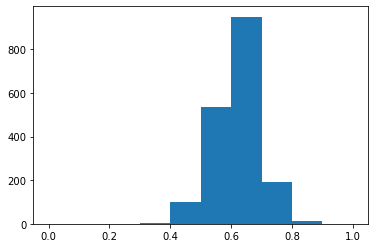

In [20]:
plt.hist(cos_similarities_untrained, range=[0.0, 1.0])

#### After Training

(array([   0.,    0.,    0.,    0.,    0.,    6.,   30.,  125.,  494.,
        1138.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

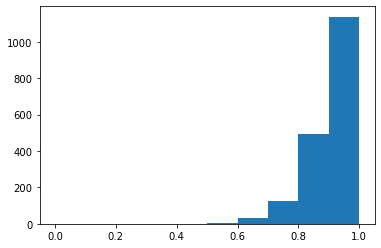

In [19]:
plt.hist(cos_similarities_trained, range=[0.0, 1.0])

## Results
+ My untrained model: 0.6206250808223026
+ My trained model: 0.9006451366337331
+ Universal sentence encoder multilingual module: 0.7107736021030966

Universal sentence encoder multilingual module
+ Developed by Google researchers
+ Multilingual support, including Japanese (16 languages)
+　Demonstrates strong performance in cross-lingual retrieval
+ Optimized for multi-word text, such as sentences, phrases, or short paragraphs
+ Input language does not need to be specified
+ Generates a 512-dimensional vector as the output
+ Designed for text classification, text clustering, semantic textual similarity retrieval, cross-lingual text retrieval, etc.


## Evaluate Model Performance
+ Short sentences: my original
+ Short paragraphs: created from the UNESCO Constitution
    + English: https://www.unesco.org/en/legal-affairs/constitution
    + Japanese: https://www.mext.go.jp/unesco/009/001.htm

In [ ]:
# scipy.spatial module is used for performing various spatial and distance-related computations
import scipy.spatial

import scipy.spatial
import MeCab

### Corpus with example sentences
corpus = ['これは例文です。',
          'この文は一例です。',
          '私は彼に数学を教えた。',
          '彼は私に数学を教えた。',
          '私はあなたを助けて嬉しい。',
          '私はあなたを喜んでお手伝いします。',
          '喜んでお手伝いします。'
          ]
#corpus = ['この憲章の当事国政府は、その国民に代わって次のとおり宣言する。',
#          '戦争は人の心の中で生れるものであるから、人の心の中に平和のとりでを築かなければならない。',
#          '相互の風習と生活を知らないことは、人類の歴史を通じて世界の諸人民の間に疑惑と不信をおこした共通の原因であり、この疑惑と不信のために、諸人民の不一致があまりにもしばしば戦争となった。',
#          'ここに終りを告げた恐るべき大戦争は、人間の尊厳・平等・相互の尊重という民主主義の原理を否認し、これらの原理の代りに、無知と偏見を通じて人間と人種の不平等という教義をひろめることによって可能にされた戦争であった。',
#          '文化の広い普及と正義・自由・平和のための人類の教育とは、人間の尊厳に欠くことのできないものであり、且つすべての国民が相互の援助及び相互の関心の精神をもって果さなければならない神聖な義務である。',
#          '政府の政治的及び経済的取極のみに基く平和は、世界の諸人民の、一致した、しかも永続する誠実な支持を確保できる平和ではない。よって平和は、失われないためには、人類の知的及び精神的連帯の上に築かなければならない。',
#          'これらの理由によって、この憲章の当事国は、すべての人に教育の充分で平等な機会が与えられ、客観的真理が拘束を受けずに探究され、且つ、思想と知識が自由に交換されるべきことを信じて、その国民の間における伝達の方法を発展させ及び増加させること並びに相互に理解し及び相互の生活を一層真実に一層完全に知るためにこの伝達の方法を用いることに一致し及び決意している。',
#          'その結果、当事国は、世界の諸人民の教育、科学及び文化上の関係を通じて、国際連合の設立の目的であり、且つその憲章が宣言している国際平和と人類の共通の福祉という目的を促進するために、ここに国際連合教育科学文化機関を創設する。'
#          ]
# encode the sentences in the corpus using the pre-trained model to obrain embeddings for each sentence
m = MeCab.Tagger("-Owakati")
corpus =  [m.parse(x).strip('\n') for x in corpus]
corpus_embeddings = model.encode(corpus)

### Query sentences
# sentences for which you want to find similar sentences in the corpus
queries = ['This is an example sentence.', 
           'I taught him math.', 
           'He taught me math.', 
           'I am happy to help you.'
          ]
#queries = ['The Governments of the States Parties to this Constitution on behalf of their peoples declare.',
#           'That since wars begin in the minds of men, it is in the minds of men that the defenses of peace must be constructed.',
#           'That ignorance of each other’s ways and lives has been a common cause, throughout the history of mankind, of that suspicion and mistrust between the peoples of the world through which their differences have all too often broken into war.',
#           'That the great and terrible war which has now ended was a war made possible by the denial of the democratic principles of the dignity, equality and mutual respect of men, and by the propagation, in their place, through ignorance and prejudice, of the doctrine of the inequality of men and races.',
#           'That the wide diffusion of culture, and the education of humanity for justice and liberty and peace are indispensable to the dignity of man and constitute a sacred duty which all the nations must fulfill in a spirit of mutual assistance and concern.',
#           'That a peace based exclusively upon the political and economic arrangements of governments would not be a peace which could secure the unanimous, lasting and sincere support of the peoples of the world, and that the peace must therefore be founded, if it is not to fail, upon the intellectual and moral solidarity of mankind.',
#           'For these reasons, the States Parties to this Constitution, believing in full and equal opportunities for education for all, in the unrestricted pursuit of objective truth, and in the free exchange of ideas and knowledge, are agreed and determined to develop and to increase the means of communication between their peoples and to employ these means for the purposes of mutual understanding and a truer and more perfect knowledge of each other’s lives.',
#           'In consequence whereof they do hereby create the United Nations Educational, Scientific and Cultural Organization for the purpose of advancing, through the educational and scientific and cultural relations of the peoples of the world, the objectives of international peace and of the common welfare of mankind  for which the United Nations Organization was established and which its Charter proclaims.'
#           ]
# encode the sentences in the queries using the pre-trained model to obrain embeddings for each sentence
query_embeddings = model.encode(queries)

### Find the closest 8 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 8
# zip is used to pair each query sentence with its corresponding embedding
for query, query_embedding in zip(queries, query_embeddings):
    # calculate the pairwise cosine similarity (distance between two array) between the query embedding and all the embeddings in the corpus
    # The result is a list of cosine distances
    # [0] is used to extract the distances from the first row
    # which contains the distances for the single query against all corpus sentences
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    # combines the list of indices with the list of cosine distances
    results = zip(range(len(distances)), distances)
    # sort these pairs in ascending order of cosine distance
    # most similar sentence comes at the beginning of the list
    # e.g. results = [(5, 0.1234), (3, 0.2345), ...]
    results = sorted(results, key=lambda x: x[1])

    # print the query sentence and the top 8 most similar senteces in the corpus
    print("\n======================\n")
    print("Query:", query)
    print("\nTop 8 most similar sentences in corpus:\n")

    # 1 - distance represent similarity (higher score means higher similarity)
    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))